In [68]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
import timm

from insightface.utils import face_align
from face_alignment.detection.blazeface import blazeface_detector
from pathlib import Path

In [3]:
class FaceSynthetics(pl.LightningModule):
    def __init__(self, backbone):
        super().__init__()
        self.save_hyperparameters()
        backbone = timm.create_model(backbone, num_classes=68*2)
        self.backbone = backbone
        self.loss = nn.L1Loss(reduction='mean')
        self.hard_mining = False

    def forward(self, x):
        # use forward for inference/predictions
        y = self.backbone(x)
        return y

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.backbone(x)
        if self.hard_mining:
            loss = torch.abs(y_hat - y) #(B,K)
            loss = torch.mean(loss, dim=1) #(B,)
            B = len(loss)
            S = int(B*0.5)
            loss, _ = torch.sort(loss, descending=True)
            loss = loss[:S]
            loss = torch.mean(loss) * 5.0
        else:
            loss = self.loss(y_hat, y) * 5.0
        self.log('train_loss', loss, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.backbone(x)
        loss = self.loss(y_hat, y)
        self.log('val_loss', loss, on_step=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.backbone(x)
        loss = self.loss(y_hat, y)
        self.log('test_loss', loss)

    def configure_optimizers(self):
        #return torch.optim.Adam(self.parameters(), lr=0.0002)
        opt = torch.optim.SGD(self.parameters(), lr = 0.1, momentum=0.9, weight_decay = 0.0005)
        def lr_step_func(epoch):
            return 0.1 ** len([m for m in [15, 25, 28] if m <= epoch])
        scheduler = torch.optim.lr_scheduler.LambdaLR(
                optimizer=opt, lr_lambda=lr_step_func)
        lr_scheduler = {
                'scheduler': scheduler,
                'name': 'learning_rate',
                'interval':'epoch',
                'frequency': 1}
        return [opt], [lr_scheduler]

In [4]:
model = FaceSynthetics.load_from_checkpoint('/home/phdomingues/masters/libs/insightface/alignment/synthetics/synthetic_resnet50d.ckpt').cuda()

/home/phdomingues/.miniconda3/envs/sam/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/migration.py:207: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
Lightning automatically upgraded your loaded checkpoint from v1.3.8 to v2.1.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../../../home/phdomingues/masters/libs/insightface/alignment/synthetics/synthetic_resnet50d.ckpt`


In [6]:
IMG_PATH = Path('/home/phdomingues/masters/data/UNIFESP/all/05_110222.bmp')
MASK_PATH = Path('/home/phdomingues/masters/results/UNIFESP360/sam/05_110222.png')

In [69]:
fd = blazeface_detector.BlazeFaceDetector(device='cuda')

In [70]:
img = cv2.imread(str(IMG_PATH))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

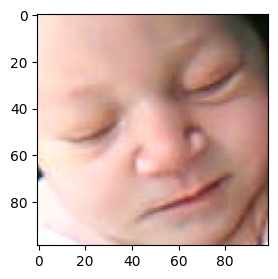

In [71]:
bbox = fd.detect_from_image(img)[0]

# Plot 
fig, ax = plt.subplots(figsize=(3,3))
ax.imshow(img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])])
plt.show()

In [72]:
#input_img = img.copy()
input_img = img.copy()[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]

In [73]:
w, h = (bbox[2] - bbox[0]), (bbox[3] - bbox[1])
center = (bbox[2] + bbox[0]) / 2, (bbox[3] + bbox[1]) / 2
rotate = 0
_scale = 256  / (max(w, h)*1.5)
aimg, M = face_align.transform(img, center, 256, _scale, rotate)

i = np.transpose(input_img, (2, 0, 1))
i = np.expand_dims(i, 0)
imgs = torch.Tensor(i).cuda()
imgs.div_(255).sub_(0.5).div_(0.5)
pred = model(imgs).detach().cpu().numpy().flatten().reshape( (-1, 2) )

pred[:, 0:2] += 1
pred[:, 0:2] *= (256 // 2)

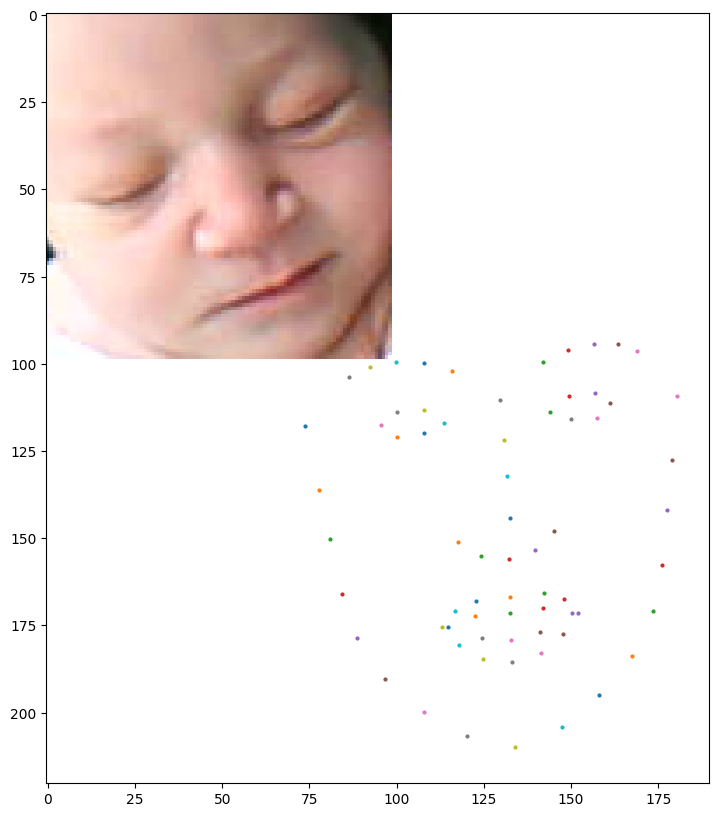

In [74]:
# Copy the original image for display purpose
display_img = input_img.copy()

# Plot 
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(display_img)
for points in pred:
    ax.scatter(points[0], points[1], 4)

plt.show()